In [4]:
!pip install torchmetrics -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [8]:
final_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Homer/final_dataset_homer.csv')

In [9]:
final_dataset.head(3)

,Unnamed: 0,A,Q,Context,len_Context,label
0,3,Me?,I'm glad I'm not crying because I would hate f...,Mr. Bergstrom left today. He's gone. Forever. ...,4.0,1.0
1,4,I don't think you realize what you're saying.,"Yes, you! Baboon, baboon, baboon, baboon!",He's gone. Forever. I didn't think you'd under...,4.0,1.0
2,5,"Did you hear that, Marge? She called me a babo...","Whoa, somebody was bound to say it one day. I ...",I didn't think you'd understand. I'm glad I'm ...,4.0,1.0


In [10]:
# Соберем все ответы из базы
base_answers = final_dataset['A']
all_answers = list(set(base_answers)) # Список всех ответов из базы

In [11]:
all_answers[1]

"Why do you think I'm kicking it?"

In [12]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Homer/bi_encoder_homer")

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [15]:
dataset = pd.DataFrame({
    "sentence1": final_dataset["A"],  # Создание поля "предложение 1" на основе данных из поля "А"
    "sentence2": final_dataset["Q"],  # Создание поля "предложение 2" на основе данных из поля "Б"
    "label": final_dataset["label"]     # Создание поля "метка 2" на основе данных из поля "метка"
})

In [16]:
MAX_LENGTH=128

In [17]:
tokenized_texts = tokenizer(dataset["sentence1"].tolist(),
                            dataset["sentence2"].tolist(),
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

In [18]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [ ]:
%%time

sts_dataset = StsDataset(tokenized_texts, dataset["label"].tolist())

In [20]:
train_ratio = 0.9
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

In [22]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [23]:
model = CrossEncoderBert().to(DEVICE)

In [26]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [24]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [25]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [26]:
%%time

n_epochs = 5

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/368, Loss = 0.667
Step    64/368, Loss = 0.302
Step   128/368, Loss = 0.082
Step   192/368, Loss = 0.122
Step   256/368, Loss = 0.079
Step   320/368, Loss = 0.125
Step     0/41, Loss = 0.227

Epoch 2
Step     0/368, Loss = 0.117
Step    64/368, Loss = 0.185
Step   128/368, Loss = 0.098
Step   192/368, Loss = 0.219
Step   256/368, Loss = 0.155
Step   320/368, Loss = 0.163
Step     0/41, Loss = 0.227

Epoch 3
Step     0/368, Loss = 0.055
Step    64/368, Loss = 0.053
Step   128/368, Loss = 0.084
Step   192/368, Loss = 0.058
Step   256/368, Loss = 0.158
Step   320/368, Loss = 0.158
Step     0/41, Loss = 0.227

Epoch 4
Step     0/368, Loss = 0.105
Step    64/368, Loss = 0.156
Step   128/368, Loss = 0.175
Step   192/368, Loss = 0.185
Step   256/368, Loss = 0.194
Step   320/368, Loss = 0.145
Step     0/41, Loss = 0.227

Epoch 5
Step     0/368, Loss = 0.108
Step    64/368, Loss = 0.147
Step   128/368, Loss = 0.104
Step   192/368, Loss = 0.119
Step   256/368, Loss = 0.114
St

In [27]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

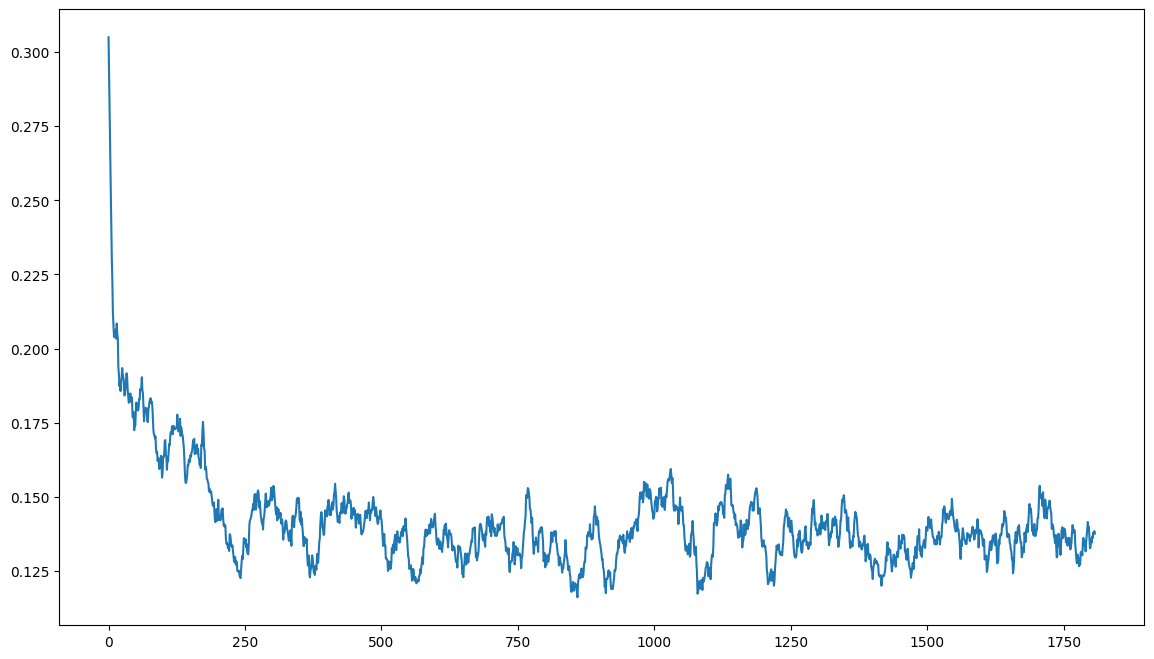

In [28]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [29]:
model.bert_model.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/Homer/cross_encoder_homer")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Homer/weights_only.pth')

In [33]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(DEVICE)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [34]:
def get_best_rand_reply(
    tokenizer: AutoTokenizer,
    finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel,
    query: str,
    context: str,
    corpus: list[str],
    size_patch = 150,
    qty_rand_choose = 5,
    max_out_context = 200
) -> None:

    dic_answ = dict()
    dic_answ["score"] = []
    dic_answ["answer"] = []

    conext_memory= query+"[SEP]"+context

    if len(corpus) < qty_rand_choose*max_out_context:
        qty_rand_choose = int(len(corpus))

    # так как база большая
    for i in range(qty_rand_choose):
        rand_patch_corpus = list(np.random.choice(corpus, size_patch))
        #print(len(rand_patch_corpus))

        queries = [conext_memory]* len(rand_patch_corpus)
        #print(len(queries))
        tokenized_texts = tokenizer(
            queries,
            rand_patch_corpus,
            max_length=MAX_LENGTH,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(DEVICE)

        # Finetuned CrossEncoder model scoring
        with torch.no_grad():
            ce_scores = finetuned_ce(tokenized_texts['input_ids'],
                                     tokenized_texts['attention_mask']).squeeze(-1)
            ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

        # Process scores for finetuned model
        scores = ce_scores.cpu().numpy()
        scores_ix = np.argsort(scores)[::-1][0]
        dic_answ["score"].append(scores[scores_ix])
        dic_answ["answer"].append(rand_patch_corpus[scores_ix])

    id = np.argsort(dic_answ["score"])[::-1][0]# np.array(dic_answ["score"]).argmax()
    answer = dic_answ["answer"][id]
    conext_memory = answer+"[SEP]"+conext_memory
  #  flush_memory()
    return answer, conext_memory[:max_out_context], dic_answ["score"][id]

In [35]:
question = "I'm glad I'm not crying because"  #
print(f"Реплика: {question}")

Реплика: I'm glad I'm not crying because


In [37]:
best_answer, conext_memory,  best_score = get_best_rand_reply(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_answers)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")

Лучший ответ: Are you kidding? It's a wondrous, marvelous thing. Marge, I need you more than anyone else on this entire planet could possibly ever need you. I need you to take care of me, to put up with me, and most of all, I need you to love me, because I love you.
score 0.7326272130012512


In [38]:
question = "Yes, you! Baboon, baboon, baboon, baboon!"  #
print(f"Реплика: {question}")

Реплика: Yes, you! Baboon, baboon, baboon, baboon!


In [39]:
best_answer, conext_memory,  best_score = get_best_rand_reply(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_answers)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")

Лучший ответ: 'Cause Marge and I have one thing that can never be broken: a strong marriage built on a solid foundation of routine. Marge, I'm home! Where are you? Are you okay? I don't smell dinner! "Dear Homer," aww. "Sorry you didn't want to join me tonight. I left you hot dogs for dinner. They're thawing in the sink."
score 0.7299624085426331


In [40]:
question = "Me?	"  #
print(f"Реплика: {question}")

Реплика: Me?	


In [41]:
best_answer, conext_memory,  best_score = get_best_rand_reply(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_answers)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")

Лучший ответ: If I know me, he won't like being kicked in the crotch. Oh, Marge. It's me, the real Homer!
score 0.7360175251960754


In [42]:
question = "Homer?"  #
print(f"Реплика: {question}")

Реплика: Homer?


In [43]:
best_answer, conext_memory,  best_score = get_best_rand_reply(
    tokenizer, model, bert_model.to(DEVICE),
    query = question,
    context = "",
    corpus = all_answers)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")

Лучший ответ: Eh. I'll do it anyway. Come on, boy, we're going to see the neighbors.
score 0.7377363443374634
